In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the package:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Create a function to get a summary of the dataset:

In [3]:
def data_info(data):
    # Create an empty DataFrame with column names matching the input data
    df = pd.DataFrame(index=data.columns)

    # Add a column to the DataFrame containing the data types of each column
    df['type'] = data.dtypes

    # Add a column to the DataFrame containing the number of null values in each column
    df['Null Value'] = data.isnull().sum()

    # Add a column to the DataFrame containing the percentage of null values in each column
    df['Nan Percent'] = round(100*(data.isnull().sum()/len(data)), 2)

    df['Unique'] = data.nunique().values

    # Sort the DataFrame by the number of null values in each column, in descending order
    return df.sort_values(by='Null Value', ascending=False)


# Import the data:

In [4]:
train = pd.read_csv('Train_zsoft.csv')
train.head()

,ID,text,label
0,17428,TRANSPORT SYTEX / OEDA,Experience
1,15362,Appliquer la résine Avancé,Skills
2,37153,2020 - 2021 ¢ Formation en ligne sur le,Education
3,10240,Score: 820 (B2),Skills
4,29713,- Anglais :courant - Créole :courant,Skills


In [5]:
data_info(train)

,type,Null Value,Nan Percent,Unique
ID,int64,0,0.0,30129
text,object,0,0.0,28378
label,object,0,0.0,3


In [6]:
test = pd.read_csv('Test_zsoft.csv')
test.head()

,ID,text
0,31507,e Coordinating and distributing shooting sched...
1,12238,Dipl6me Universitaire en Production de Contenu...
2,37232,Professeur Patrick Cohen.
3,22248,"e Autonomie, sens de la responsabilité"
4,4589,2021-2023 2020-2021 2017-2019


In [7]:
test.shape

(7533, 2)

In [8]:
data_info(test)

,type,Null Value,Nan Percent,Unique
ID,int64,0,0.0,7533
text,object,0,0.0,7361


In [107]:
Submission = pd.read_csv('SampleSubmission_zsoft.csv')
Submission.head()

,ID,label
0,31507,Education
1,12238,Education
2,37232,Education
3,22248,Education
4,4589,Education


# Explore the data:

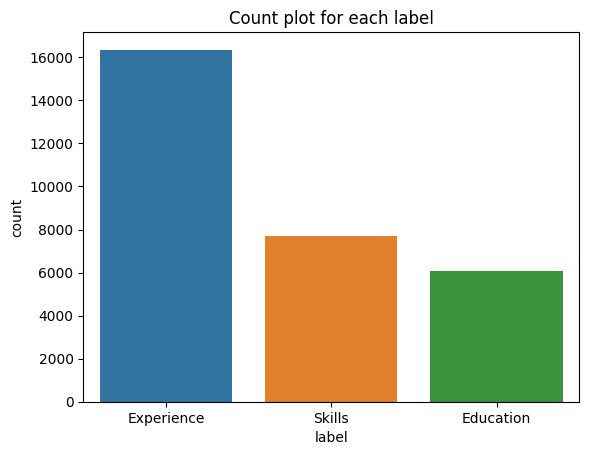

In [10]:
sns.countplot(data=train, x='label')

plt.title('Count plot for each label')
plt.show()

In [11]:
train.label.value_counts()

Experience    16352
Skills         7691
Education      6086
Name: label, dtype: int64

## Remove Duplicate values:

In [12]:
num_duplicates = train['text'].duplicated(keep=False).sum()

print("Number of duplicate values:", num_duplicates)

Number of duplicate values: 2790


In [13]:
# Identify duplicate rows based on 'text' and 'label' columns
duplicates = train.duplicated(subset=['text', 'label'], keep=False)

# Extract only the duplicate rows
duplicate_rows = train.loc[duplicates]

# Group the duplicate rows by their unique values and get the indices
groups = duplicate_rows.groupby(['text', 'label']).groups


duplicate_list = []
# Print the indices of each pair of duplicate rows
for group, indices in groups.items():
    duplicate_tuple = (group, indices)
    duplicate_list.append(duplicate_tuple)

In [14]:
duplicate_list[:3]

[(('( école de formation professionnelle unibeauté )', 'Education'),
  Int64Index([9188, 14503, 21914], dtype='int64')),
 (('(2022-2023)', 'Education'), Int64Index([4283, 26301], dtype='int64')),
 (('(3 semaines)', 'Experience'),
  Int64Index([7323, 14128, 15298], dtype='int64'))]

In [15]:
# for example we se that the text 'école de formation professionnelle unibeauté' with the label: 'Education' appears 3 times: [9188, 14503, 21914]

indexes = duplicate_list[0][1].tolist()

for index in indexes:
    print(train.iloc[index][['text', 'label']])

text     ( école de formation professionnelle unibeauté )
label                                           Education
Name: 9188, dtype: object
text     ( école de formation professionnelle unibeauté )
label                                           Education
Name: 14503, dtype: object
text     ( école de formation professionnelle unibeauté )
label                                           Education
Name: 21914, dtype: object


In [16]:
# Remove the duplicates values and keep only the first:

train = train.drop_duplicates(subset=["text", "label"] , keep='first')
print("see if there is any duplicated value: ",train.duplicated(subset=['text', 'label'], keep=False).sum())
train.shape


see if there is any duplicated value:  0


(28515, 3)

In [17]:
train.head()

,ID,text,label
0,17428,TRANSPORT SYTEX / OEDA,Experience
1,15362,Appliquer la résine Avancé,Skills
2,37153,2020 - 2021 ¢ Formation en ligne sur le,Education
3,10240,Score: 820 (B2),Skills
4,29713,- Anglais :courant - Créole :courant,Skills


# Processing the data:

In [18]:
train.label.value_counts()

Experience    15730
Skills         6973
Education      5812
Name: label, dtype: int64

In [19]:
train['label'] = train['label'].map({ 'Experience' : 0  ,'Skills' : 1 ,'Education' :2})
train.head()

<ipython-input-19-d1ad0546ca56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = train['label'].map({ 'Experience' : 0  ,'Skills' : 1 ,'Education' :2})


,ID,text,label
0,17428,TRANSPORT SYTEX / OEDA,0
1,15362,Appliquer la résine Avancé,1
2,37153,2020 - 2021 ¢ Formation en ligne sur le,2
3,10240,Score: 820 (B2),1
4,29713,- Anglais :courant - Créole :courant,1


In [21]:
import datasets

In [22]:
from datasets import Dataset

# Converting the input data from Pandas DataFrames to Dataset objects :
train_ds = datasets.Dataset.from_pandas(train)
# test_ds = datasets.Dataset.from_pandas(test)


train_ds

Dataset({
    features: ['ID', 'text', 'label', '__index_level_0__'],
    num_rows: 28515
})

### Split the train_ds into train set and validation set

In [23]:
train_ds = train_ds.train_test_split(train_size=0.8, seed=42)
train_ds['val'] = train_ds.pop("test")
train_ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'label', '__index_level_0__'],
        num_rows: 22812
    })
    val: Dataset({
        features: ['ID', 'text', 'label', '__index_level_0__'],
        num_rows: 5703
    })
})

In [24]:
train_ds['train'][10]

{'ID': 17993,
 'text': 'PAO et photogravure pout |’Oréal, YSL, Biotherm, Dior, Vuitton, Toyota, Renault',
 'label': 0,
 '__index_level_0__': 17365}

### LowererCase The text:

In [25]:
def lowercase_condition(example):
    return {"text": example["text"].lower()}

train_ds = train_ds.map(lowercase_condition)
# Check that lowercasing worked
train_ds["train"]["text"][:3]

Map:   0%|          | 0/22812 [00:00<?, ? examples/s]

Map:   0%|          | 0/5703 [00:00<?, ? examples/s]

['- suivi des compétences',
 '- 1983: cnam: valeur technique financiére et comptable de |’ entreprise',
 'photographe auteure-artiste (deuxiéme activité)']

In [26]:
train_ds["val"]["text"][:3]

['commandes, service a table et buffet...',
 'service des vins',
 '> espagnol niveau b2']

# Prepare for training:

## Tokenize:

In [27]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0


In [28]:
# Load the `cammebert-base` model and tokenizer from transformers:

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

checkpoint = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)


(…)/camembert-base/resolve/main/config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

(…)ase/resolve/main/sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

(…)membert-base/resolve/main/tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### define a function that tokenizes our inputs:

In [29]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

In [30]:
train_ds_tokenized = train_ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/22812 [00:00<?, ? examples/s]

Map:   0%|          | 0/5703 [00:00<?, ? examples/s]

In [31]:
train_ds_tokenized

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 22812
    })
    val: Dataset({
        features: ['ID', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5703
    })
})

**Now we'll rename the column label to labels because the model expects the argument to be named labels.** <br>

**Also we'll remove the text and the ID columns:**

In [38]:
train_ds = train_ds_tokenized.remove_columns(["ID", "text","__index_level_0__"])

train_ds = train_ds.rename_column("label", "labels")

In [39]:
# To return a Pytorch tensors instead of lists.
train_ds.set_format("torch")

# Get the names of the new columns:
train_ds["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [40]:
train_ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 22812
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5703
    })
})

### Define our dataloaders:

In [41]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_ds["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    train_ds["val"], batch_size=8, collate_fn=data_collator
)

**Check if there is a mistake in the data processing:**

In [42]:
for batch in train_dataloader:
    break

{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 26]),
 'attention_mask': torch.Size([8, 26])}

In [43]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.1265, grad_fn=<NllLossBackward0>) torch.Size([8, 3])


### So There is no mistake

Now we'll turn to the model

In [44]:
# Define our optimizer:

from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

8556


# The training loop:

**Define a device to use the GPU:**

In [46]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [48]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
train_loss = []
val_loss = []

model.train()
for epoch in range(num_epochs):
    sum_epoch_loss= []

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        sum_epoch_loss.append(loss.item())

        progress_bar.update(1)

    # Calculate and record the average training loss for the epoch
    avg_epoch_loss = sum(sum_epoch_loss) / len(train_dataloader)
    train_loss.append(avg_epoch_loss)

    # Calculate the validation loss at the end of each epoch
    model.eval()
    with torch.no_grad():
        sum_epoch_val_loss = []
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            sum_epoch_val_loss.append(loss.item())

        avg_epoch_val_loss = sum(sum_epoch_val_loss) / len(eval_dataloader)
        val_loss.append(avg_epoch_val_loss)

    model.train()

  0%|          | 0/8556 [00:00<?, ?it/s]

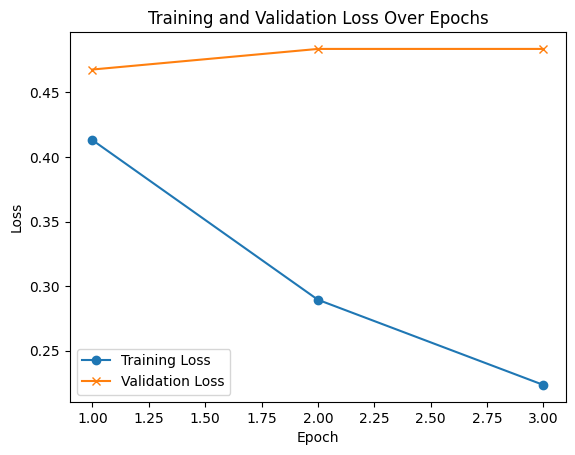

In [53]:
# Plotting the losses for each epoch:
plt.plot(range(1, num_epochs + 1), train_loss, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, marker='x', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()  # Add legend to differentiate between training and validation loss
plt.show()


# The evaluation loop:

In [54]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00


In [55]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])



In [57]:
# Get the accuracy:
metric.compute()

ValueError: ignored

A good result, now I will train the model over all the train data

# Train for all the data:

In [58]:
train.head()

,ID,text,label
0,17428,TRANSPORT SYTEX / OEDA,0
1,15362,Appliquer la résine Avancé,1
2,37153,2020 - 2021 ¢ Formation en ligne sur le,2
3,10240,Score: 820 (B2),1
4,29713,- Anglais :courant - Créole :courant,1


In [59]:
train_ds = Dataset.from_pandas(train)
train_ds

Dataset({
    features: ['ID', 'text', 'label', '__index_level_0__'],
    num_rows: 28515
})

In [60]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

checkpoint = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
model.to(device)
device

device(type='cuda')

In [62]:
train_ds_tokenized = train_ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/28515 [00:00<?, ? examples/s]

In [63]:
train_ds_tokenized

Dataset({
    features: ['ID', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 28515
})

In [64]:
train_ds = train_ds_tokenized.remove_columns(["ID", "text", "__index_level_0__"])

train_ds = train_ds.rename_column("label", "labels")

In [65]:
# To return a Pytorch tensors instead of lists.
train_ds.set_format("torch")

# Get the names of the new columns:
train_ds.column_names

['labels', 'input_ids', 'attention_mask']

In [66]:
train_ds

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 28515
})

In [67]:
train_dataloader = DataLoader(
    train_ds, shuffle=True, batch_size=8, collate_fn=data_collator
)

In [68]:
for batch in train_dataloader:
    break

{k: v.shape for k, v in batch.items()}

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 34]),
 'attention_mask': torch.Size([8, 34])}

In [69]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

RuntimeError: ignored

In [70]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [71]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

10695


In [72]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/10695 [00:00<?, ?it/s]

# Test set :

In [73]:
test_df = test.copy()
test_df = test_df.drop('ID', axis=1)

test_ds = Dataset.from_pandas(test_df)

In [74]:
test_ds

Dataset({
    features: ['text'],
    num_rows: 7533
})

In [75]:
test_ds_tokenized = test_ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/7533 [00:00<?, ? examples/s]

In [76]:
test_ds_tokenized

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 7533
})

In [77]:
test_ds = test_ds_tokenized.remove_columns(["text"])

test_ds

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 7533
})

In [78]:
# To return a Pytorch tensors instead of lists.
test_ds.set_format("torch")

# Get the names of the new columns:
test_ds.column_names

['input_ids', 'attention_mask']

In [79]:
test_dataloader = DataLoader(
    test_ds, batch_size=8, collate_fn=data_collator
)

In [80]:
prediction = []

model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    prediction.extend(predictions.tolist())



In [96]:
test['label'] = prediction
test.head()

,ID,text,label
0,31507,e Coordinating and distributing shooting sched...,0
1,12238,Dipl6me Universitaire en Production de Contenu...,2
2,37232,Professeur Patrick Cohen.,2
3,22248,"e Autonomie, sens de la responsabilité",1
4,4589,2021-2023 2020-2021 2017-2019,2


In [97]:
test['label'] = test['label'].map({0:'Experience', 1:'Skills', 2:'Education'})

test.head()

,ID,text,label
0,31507,e Coordinating and distributing shooting sched...,Experience
1,12238,Dipl6me Universitaire en Production de Contenu...,Education
2,37232,Professeur Patrick Cohen.,Education
3,22248,"e Autonomie, sens de la responsabilité",Skills
4,4589,2021-2023 2020-2021 2017-2019,Education


In [98]:
test.label.value_counts()

Experience    4190
Skills        1814
Education     1529
Name: label, dtype: int64

In [99]:
import os

# Define the directory path
directory_path = "/content/drive/MyDrive/Colab Notebooks/"

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

In [100]:
# Define the file path where you want to save the CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Zsoft_test.csv"

# Save the DataFrame to a CSV file
test.to_csv(file_path, index=False)

In [108]:
if (test['ID'] != Submission['ID']).all():

  raise Exception(f"Error")


else:

  print(f"Everything is Good")

Everything is Good


In [109]:
Submission['label'] = prediction
Submission['label'] = Submission['label'].map({0:'Experience', 1:'Skills', 2:'Education'})

Submission.head()

,ID,label
0,31507,Experience
1,12238,Education
2,37232,Education
3,22248,Skills
4,4589,Education


In [90]:
# Indexes = []
# for index in range(len(Submission)):
#   if(Submission.loc[index, 'ID'] == test.loc[index, 'ID']):
#     Submission.loc[index, 'label2'] = test.loc[index, 'label']
#   else:
#     Indexes.append(Submission.loc[index, 'ID'])

In [ ]:
# Submission = Submission.drop(columns='label')
# Submission = Submission.rename(columns={'label2': 'label'})

# Submission.head()

In [110]:
Submission.label.value_counts()

Experience    4190
Skills        1814
Education     1529
Name: label, dtype: int64

In [111]:
import os

# Define the directory path
directory_path = "/content/drive/MyDrive/Colab Notebooks/"

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)


In [112]:
# Define the file path where you want to save the CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Zsoft_Submission_final1.csv"

# Save the DataFrame to a CSV file
Submission.to_csv(file_path, index=False)

In [113]:
try:
    Submission.to_csv(file_path, index=False)
    print("File saved successfully.")
except Exception as e:
    print(f"Error saving file: {e}")


File saved successfully.


In [ ]:
import os
os.listdir(directory_path)
